In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

from tqdm import tqdm
from multiprocessing import Pool

In [2]:
df = pd.read_pickle('../data/watch_list_clean.pkl.xz')

## Normalize User Ratings to their own rating behavior

In [3]:
df.head()

,title,url,username,status,times_watched,user_rating,num_eps,is_ongoing,duration,studio,start_year,end_year,season,avg_rating,num_votes,synopsis,tags,content_warnings
0,Day Break Illusion: il sole penetra le illusioni,https://www.anime-planet.com/anime/day-break-i...,Ruth,Watched,1,3.0,13,False,NaN,AIC,2013.0,2013.0,Summer,3.158,1980,Akari has always known two things: she’s a ski...,"[Drama, Fantasy, Horror, Magical Girl, Contemp...",None
1,Dog Days,https://www.anime-planet.com/anime/dog-days,Ruth,Watched,1,3.5,13,False,NaN,Seven Arcs,2011.0,2011.0,Spring,3.524,9447,"In the magical land of Flonyard, animal-eared ...","[Action, Adventure, Ecchi, Fantasy, Animal Cha...",None
2,Dog Days',https://www.anime-planet.com/anime/dog-days-2,Ruth,Watched,1,3.0,13,False,NaN,Seven Arcs,2012.0,2012.0,Summer,3.651,5345,Three months have passed since Shinku returned...,"[Action, Adventure, Ecchi, Fantasy, Animal Cha...",None
3,Fantasista Doll,https://www.anime-planet.com/anime/fantasista-...,Ruth,Watched,1,2.5,12,False,NaN,Hoods Entertainment,2013.0,2013.0,Summer,2.918,1206,Uzume Uno was on her way to class one day when...,"[Magical Girl, Sci Fi, Seinen, Slice of Life, ...",None
4,Fate/Kaleid Liner Prisma Illya,https://www.anime-planet.com/anime/fate-kaleid...,Ruth,Watched,1,3.5,10,False,NaN,SILVER LINK.,2013.0,2013.0,Summer,3.513,5655,Illya loves magical girls; but more than anyth...,"[Action, Fantasy, Magical Girl, Shounen, Conte...",None


In [28]:
scaler = RobustScaler()
def user_rating_normalizer(group):
    # return ((data - data.median()) / (data.quantile(0.75) - data.quantile(0.25))).replace(np.NaN, 0)
    scaled = scaler.fit_transform(group[['user_rating']])
    return pd.Series(scaled.reshape(1, scaled.shape[0])[0], index=group.index)

In [29]:
def applyParallel(groups, func):
    num_workers = 16
    with Pool(num_workers) as p:
        return pd.concat(p.map(func, [group for name, group in groups])).sort_index()

In [30]:
%%time
df['adj_user_rating'] = applyParallel(df.groupby('username'), user_rating_normalizer)

CPU times: user 1min 2s, sys: 1.93 s, total: 1min 4s
Wall time: 1min 5s


In [36]:
df['adj_user_rating'].agg(['min', 'max'])

min   -36.0
max    16.0
Name: adj_user_rating, dtype: float32

(-10.0, 4.0)

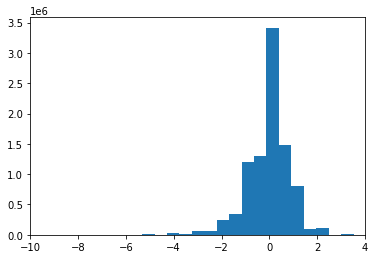

In [57]:
plt.hist(df['adj_user_rating'], bins=100)
plt.xlim(-10, 4)

<AxesSubplot:xlabel='adj_user_rating'>

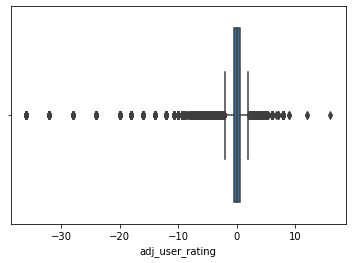

In [39]:
sns.boxplot(data=df, x='adj_user_rating')

## Normalize Average Ratings

In [47]:
scaler = RobustScaler()
def avg_rating_normalizer(data):
    # return ((data - data.median()) / (data.quantile(0.75) - data.quantile(0.25))).replace(np.NaN, 0)
    scaled = scaler.fit_transform(data[['avg_rating']])
    return pd.Series(scaled.reshape(1, scaled.shape[0])[0], index=data.index)

In [51]:
df['adj_avg_rating'] = avg_rating_normalizer(df)

In [52]:
df['adj_avg_rating'].agg(['min', 'max'])

min   -5.170343
max    1.442886
Name: adj_avg_rating, dtype: float32

(-5.0, 2.0)

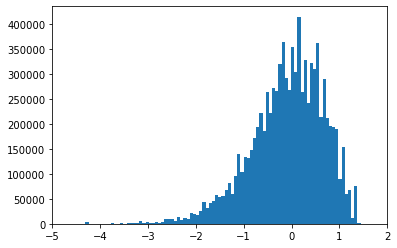

In [54]:
plt.hist(df['adj_avg_rating'], bins=100)
plt.xlim(-5, 2)